## We first loaded the intrinsic matrices and distortion coefficients calculated from our code in calibration.py

In [1]:
import numpy as np

with np.load('intrinsics/aryan_calibration_data.npz') as calibration_data:
    callibration1 = calibration_data['mtx']
    distortion1 = calibration_data['dist'][0]

print("left camera:")
print(callibration1)
print(distortion1)

with np.load('intrinsics/shreyansh_calibration_data.npz') as calibration_data:
    callibration2 = calibration_data['mtx']
    distortion2 = calibration_data['dist'][0]

print("\nright camera:")
print(callibration2)
print(distortion2)

left camera:
[[3.04178524e+03 0.00000000e+00 1.58771586e+03]
 [0.00000000e+00 3.03739654e+03 1.51810990e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[ 3.94833030e-02 -4.67790713e-01  1.20152321e-03  5.50505183e-04
  1.81732987e+00]

right camera:
[[3.35335776e+03 0.00000000e+00 1.14263851e+03]
 [0.00000000e+00 3.36079956e+03 1.98509186e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[ 4.28376981e-01 -3.29428514e+00 -1.12620290e-02 -4.65517348e-04
  7.82166843e+00]


## 2. Next we estimate the extrinsic parameters between the two cameras using keypoint correspondences of the stereo image captures

Invalid SOS parameters for sequential JPEG


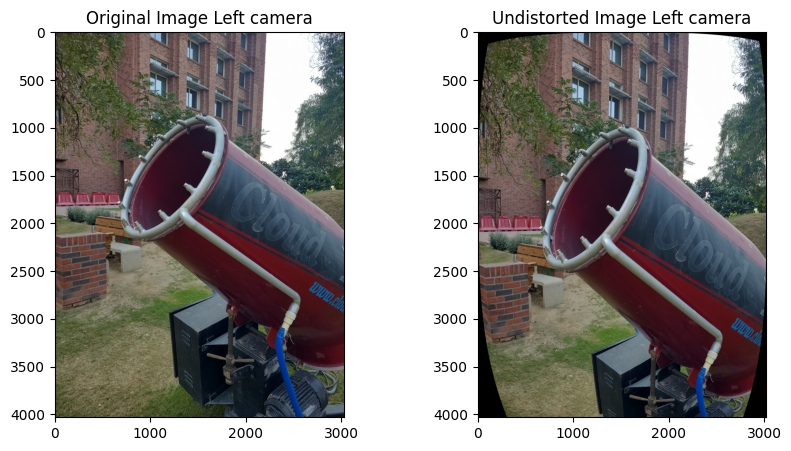

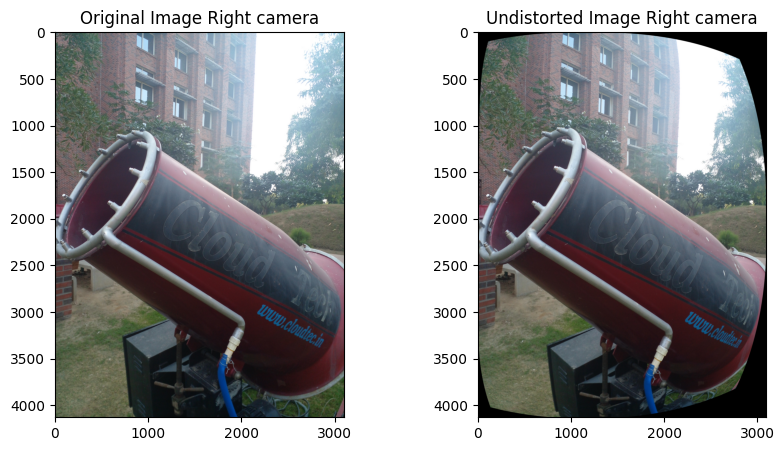

Rotation matrix:
[[ 0.9967573  -0.08027871 -0.00549611]
 [ 0.07988904  0.9954606  -0.05172935]
 [ 0.00962392  0.05112253  0.99864602]]
Translation vector:
[[-0.90008628]
 [ 0.1045613 ]
 [ 0.42297945]]


In [2]:
# use the intrinsics and distortion coefficients to undistort the images, and get the extrinsics

import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('datasets/Aryan_water_dispenser/1.jpg')
img2 = cv2.imread('datasets/shreyansh_water_dispenser/1.jpg')

K1 = callibration1
D1 = distortion1
K2 = callibration2
D2 = distortion2

# 1. first we need to undistort the images
h1, w1 = img1.shape[:2]
newK1, roi1 = cv2.getOptimalNewCameraMatrix(K1, D1, (w1, h1), 1, (w1, h1))

h2, w2 = img2.shape[:2]
newK2, roi2 = cv2.getOptimalNewCameraMatrix(K2, D2, (w2, h2), 1, (w2, h2))


img1_undistorted = cv2.undistort(img1, K1, D1, None, newK1)
img2_undistorted = cv2.undistort(img2, K2, D2, None, newK2)

# plot original and undistorted images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image Left camera')
plt.subplot(122)
plt.imshow(cv2.cvtColor(img1_undistorted, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image Left camera')
plt.show()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Original Image Right camera')
plt.subplot(122)
plt.imshow(cv2.cvtColor(img2_undistorted, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image Right camera')
plt.show()

# 2. then we perform feature detection and get matching keypoints

img1_undistorted_copy = img1_undistorted.copy()
img2_undistorted_copy = img2_undistorted.copy()

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1_undistorted, None)
kp2, des2 = sift.detectAndCompute(img2_undistorted, None)
# match features using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)
# filter out the bad matches using lowe's ratio test
good_matches = []
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance] 
# get the matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# 3. next we use the matched keypoints to get the fundamental matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
# we select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# 4. we use the fundamental matrix to get the essential matrix
E = np.dot(np.dot(K2.T, F), K1)
# we decompose the essential matrix to get the rotation and translation
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K1)

print("Rotation matrix:")
print(R)
print("Translation vector:")
print(t)

## 3. We use homography to verify that our rotation and translation matrices are correct

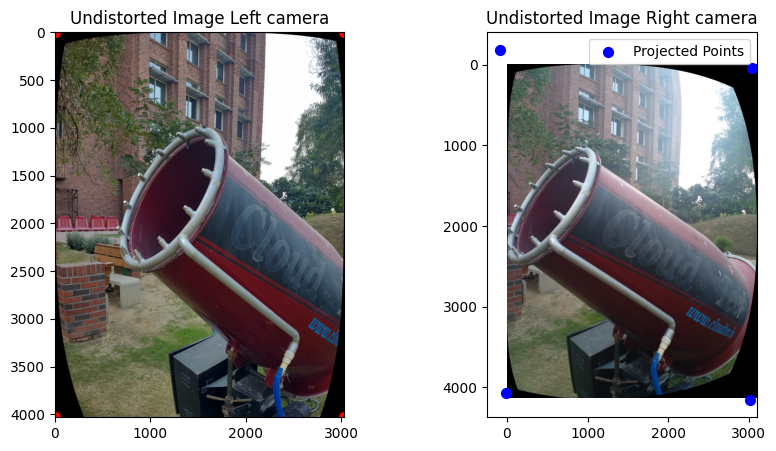

In [3]:
import matplotlib.pyplot as plt

P1 = np.dot(newK1, np.hstack((np.eye(3), np.zeros((3, 1)))))  # Left camera: P1 = K1 * [I|0]
P2 = np.dot(newK2, np.hstack((R, t)))  # Right camera: P2 = K2 * [R|t]

h, w = img1_undistorted.shape[:2]
points1 = np.array([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]], dtype=np.float32).T

points1_homogeneous = np.vstack((points1, np.ones((1, points1.shape[1]))))

points_3D_homogeneous = cv2.triangulatePoints(P1, P2, points1[:2], points1[:2])

points_3D = points_3D_homogeneous[:3] / points_3D_homogeneous[3]

projected_points_homogeneous = np.dot(P2, np.vstack((points_3D, np.ones((1, points_3D.shape[1])))))
projected_points = projected_points_homogeneous[:2] / projected_points_homogeneous[2]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(cv2.cvtColor(img1_undistorted, cv2.COLOR_BGR2RGB))
axs[0].scatter(points1[0], points1[1], c='red', s=50, label='Original Points')
axs[0].set_title('Undistorted Image Left camera')

axs[1].imshow(cv2.cvtColor(img2_undistorted, cv2.COLOR_BGR2RGB))
axs[1].scatter(projected_points[0], projected_points[1], c='blue', s=50, label='Projected Points')
axs[1].set_title('Undistorted Image Right camera')

plt.legend()
plt.show()


Same code as above with more points taken from the left image

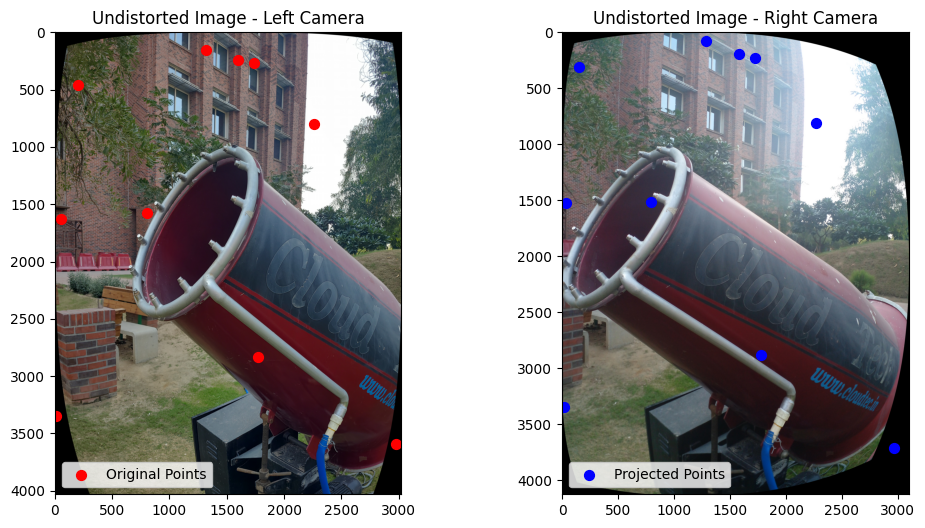

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
P1 = np.dot(newK1, np.hstack((np.eye(3), np.zeros((3, 1)))))  # Left camera: P1 = K1 * [I|0]
P2 = np.dot(newK2, np.hstack((R, t)))  # Right camera: P2 = K2 * [R|t]
h, w = img1_undistorted.shape[:2]
num_points = 10
points1 = np.random.rand(2, num_points) * [[w], [h]]
points1_homogeneous = np.vstack((points1, np.ones((1, points1.shape[1]))))
points_3D_homogeneous = cv2.triangulatePoints(P1, P2, points1[:2], points1[:2])
points_3D = points_3D_homogeneous[:3] / points_3D_homogeneous[3]
projected_points_homogeneous = np.dot(P2, np.vstack((points_3D, np.ones((1, points_3D.shape[1])))))
projected_points = projected_points_homogeneous[:2] / projected_points_homogeneous[2]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(cv2.cvtColor(img1_undistorted, cv2.COLOR_BGR2RGB))
axs[0].scatter(points1[0], points1[1], c='red', s=50, label='Original Points')
axs[0].set_title('Undistorted Image - Left Camera')
axs[0].legend()
axs[1].imshow(cv2.cvtColor(img2_undistorted, cv2.COLOR_BGR2RGB))
axs[1].scatter(projected_points[0], projected_points[1], c='blue', s=50, label='Projected Points')
axs[1].set_title('Undistorted Image - Right Camera')
axs[1].legend()
plt.show()


Image sizes do not match! Resizing right image from (4128, 3096, 3) to (4032, 3024, 3).


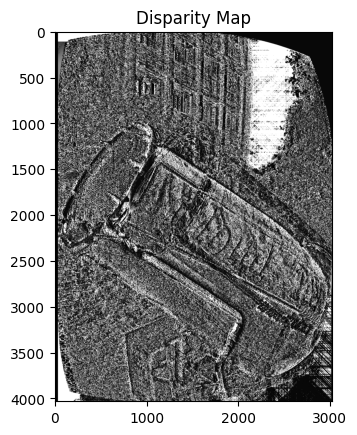

In [87]:
# img_left_gray = cv2.cvtColor(img1_undistorted, cv2.COLOR_BGR2RGB)
# img_right_gray = cv2.cvtColor(img2_undistorted, cv2.COLOR_BGR2RGB)
img_left_gray = img1_undistorted
img_right_gray = img2_undistorted
if img_left_gray.shape != img_right_gray.shape:
    print(f"Image sizes do not match! Resizing right image from {img_right_gray.shape} to {img_left_gray.shape}.")
    img_right_gray = cv2.resize(img_right_gray, (img_left_gray.shape[1], img_left_gray.shape[0]))
    
stereo = cv2.StereoSGBM_create(numDisparities=32, blockSize=5)
# stereo = cv2.StereoSGBM_create(
#     minDisparity=10,
#     numDisparities=16 * 4,  # Disparities must be a multiple of 16
#     blockSize=10,
#     P1=8 * 3 * 5 ** 2,
#     P2=32 * 3 * 5 ** 2
# )
disparity = stereo.compute(img_left_gray, img_right_gray)

disparity_norm = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(disparity_norm, cmap='gray')
plt.title(f"Disparity Map")
plt.show()

In [68]:
img_left_gray.shape

(4032, 3024, 3)

In [105]:
import open3d as o3d

Q = np.zeros((4, 4))
R = np.identity(3)  # Rotation matrix
imageSize = (img_left_gray.shape[1], img_left_gray.shape[0])  # (width, height)
cv2.stereoRectify(cameraMatrix1=callibration1, cameraMatrix2=callibration2,
                  distCoeffs1=distortion1, distCoeffs2=distortion2,
                  imageSize=imageSize,  # Use (width, height)
                  R=R, T=np.array([0.54, 0., 0.]),
                  R1=None, R2=None, P1=None, P2=None, Q=Q)

points_3D = cv2.reprojectImageTo3D(disparity, Q)
mask = disparity > disparity.min()  # Valid disparity values
points_3D = points_3D[mask]

# Normalize and ensure colors are in the correct range
colors = img_left_gray[mask].astype(np.float32) / 255.0

# Remove invalid 3D points
valid_mask = ~np.isnan(points_3D).any(axis=1) & ~np.isinf(points_3D).any(axis=1)
points_3D = points_3D[valid_mask]
colors = colors[valid_mask]

# Convert to Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3D)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd], zoom=0.8,
                                  front=[0.0, 0.0, -1.0],
                                  lookat=pcd.get_center(),
                                  up=[0.0, 1.0, 0.0])

In [103]:
np.asarray(pcd.points)

array([[ 1.63624477,  2.25168061, -3.48288918],
       [ 1.63515604,  2.25168061, -3.48288918],
       [ 1.63406742,  2.25168061, -3.48288918],
       ...,
       [        inf,         inf,         inf],
       [        inf,         inf,         inf],
       [        inf,         inf,         inf]])

In [100]:
points_normalized = np.asarray(pcd.points) - np.mean(np.asarray(pcd.points), axis=0)
points_normalized

array([], shape=(0, 3), dtype=float64)

# Reconstruction from Video

For this task, we convert the video to frames and repeat the reconstruction by matching frame images.

In our setup, we had started the cameras at the same time, but the were not closed at the same time so we have clipped the additonal part from the left camera video

In [11]:
# laod the two video files

import cv2
import numpy as np

cap1 = cv2.VideoCapture('datasets/Video/aryan_left.mp4')
cap2 = cv2.VideoCapture('datasets/Video/shreyansh_right.mp4')

# clip the additional frames from the longer video
frame_count1 = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))

frame_count2 = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))

print(frame_count1, frame_count2)

frame_count = min(frame_count1, frame_count2)

print(frame_count)

def convert_video_to_frames(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)
    counter = 0
    for i in range(frame_count):
        ret, frame = cap.read()
        if ret and counter % 50 == 0:
            frame_filename = os.path.join(output_folder, f"{i}.jpg")
            cv2.imwrite(frame_filename, frame)
        counter += 1
    cap.release()

convert_video_to_frames('datasets/Video/aryan_left.mp4', 'datasets/video_left_camera')
convert_video_to_frames('datasets/Video/shreyansh_right.mp4', 'datasets/video_right_camera')


1002 973
973
